<a href="https://colab.research.google.com/github/jimtoberfest/Cointegration_Testing/blob/main/Large_Cointegration_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install yfinance -q

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 9.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


#Imports

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import scipy

import statsmodels
import statsmodels.api as sm

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [4]:
# Doesnt work well...need to fix some yFinance integrations



def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,2),dtype=object)
    m = 0
    #loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                m = m +1
    return result, pvalue_matrix,  pairs

In [5]:
# Basic cointegration

def cointegration(a, b):
  if ts.coint(a, b)[1] < 0.05:
    print('The series are cointegrated')
    print('p-value = ', ts.coint(a, b)[1])
  else:
    print('The series are NOT cointegrated')
    print('p-value = ', ts.coint(a, b)[1])

In [6]:
def stationarity(a, cutoff = 0.05):
  a = np.ravel(a)
  if adfuller(a)[1] < cutoff:
    print('The series is stationary')
    print('p-value = ', adfuller(a)[1])
  else:
    print('The series is NOT stationary')
    print('p-value = ', adfuller(a)[1])

# Initial Testing

## Download Data

In [7]:
# HST vs DRH, 



today = datetime.today()
sp_list = ['BDX','ALL']
offset = max(1, (today.weekday() + 6) % 7 - 3)
timed = timedelta(offset)
today_business = today - timed
print("d1 =", today_business)
today = today_business.strftime("%Y-%m-%d")
start = '2019-01-01' 
end = today
# end = '2018-01-01'
end = '2021-12-31'
print('S&P500 Stock download')
spy = yf.download(sp_list, start,end)

d1 = 2022-01-27 22:15:39.247887
S&P500 Stock download
[*********************100%***********************]  2 of 2 completed


## **Sofien Based Code**

In [8]:
EWC = spy['Adj Close'][sp_list[0]].values
EWA = spy['Adj Close'][sp_list[1]].values

S1 = EWC
S2 = EWA

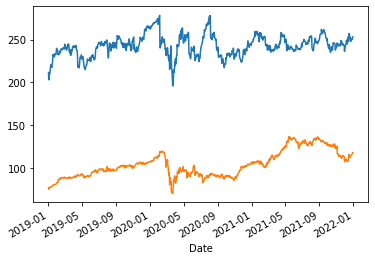

In [9]:
spy['Adj Close'][sp_list[0]].plot()
spy['Adj Close'][sp_list[1]].plot()

### Pearson Correlation

In [10]:
np.corrcoef(S1, S2)

array([[1.        , 0.39645678],
       [0.39645678, 1.        ]])

In [11]:
scipy.stats.pearsonr(S1,S2)

(0.3964567776005438, 7.31664275536486e-30)

### Stationarity

In [12]:
stationarity(S1)

The series is stationary
p-value =  0.00030508362910956023


In [13]:
stationarity(S2)

The series is NOT stationary
p-value =  0.3285679214438465


### Cointegration

In [14]:
cointegration(S1,S2)

The series are cointegrated
p-value =  0.0012150218746699976


##Explore DF

In [15]:
df = pd.DataFrame(columns=['S1', 'S2'])

In [16]:
# Trying to make time series stationary in some way... trying log diff of prices and simple ratio of prices
# Then calculating 2 stdev bands, to see if asset prices revert to mean after exceeding 2 or 2.5 stdev up or down


df['S1']= S1.tolist()
df['S2']= S2.tolist()
df['s1_log'] = np.log(df['S1'] / df['S1'].shift(1))
df['s2_log'] = np.log(df['S2'] / df['S2'].shift(1))
df['log_ratio'] = df['s2_log'] / df['s1_log'] 
df['ratio'] = df['S2'] / df['S1']

window = 42
zs = 2.0

df['log_30_mean'] = df['log_ratio'].rolling(window=window).mean()
df['log_30_std'] = df['log_ratio'].rolling(window=window).std()

df['30_mean'] = df['ratio'].rolling(window=window).mean()
df['30_std'] = df['ratio'].rolling(window=window).std()


df['up_2'] = df['30_mean'] + (df['30_std'] * zs)
df['down_2'] = df['30_mean'] - (df['30_std'] * zs)
df['up_1'] = df['30_mean'] + (df['30_std'] * zs/2)
df['down_1'] = df['30_mean'] - (df['30_std'] * zs/2)

# df['log_up_2'] = df['log_30_mean'] + (df['log_30_std'] * 6)
# df['log_down_2'] = df['log_30_mean'] - (df['log_30_std'] * 6)



df.fillna(0, inplace=True)

In [17]:
df.tail(3)

,S1,S2,s1_log,s2_log,log_ratio,ratio,log_30_mean,log_30_std,30_mean,30_std,up_2,down_2,up_1,down_1
753,250.210007,117.089996,-0.004426,0.008663,-1.957141,0.467967,0.627372,5.588403,0.463685,0.022126,0.507937,0.419433,0.485811,0.441559
754,252.789993,117.949997,0.010258,0.007318,0.713355,0.466593,0.653904,5.586046,0.462247,0.019744,0.501735,0.422758,0.481991,0.442502
755,253.259995,117.680000,0.001858,-0.002292,-1.233736,0.464661,0.749480,5.516512,0.461063,0.017953,0.496970,0.425157,0.479016,0.443110


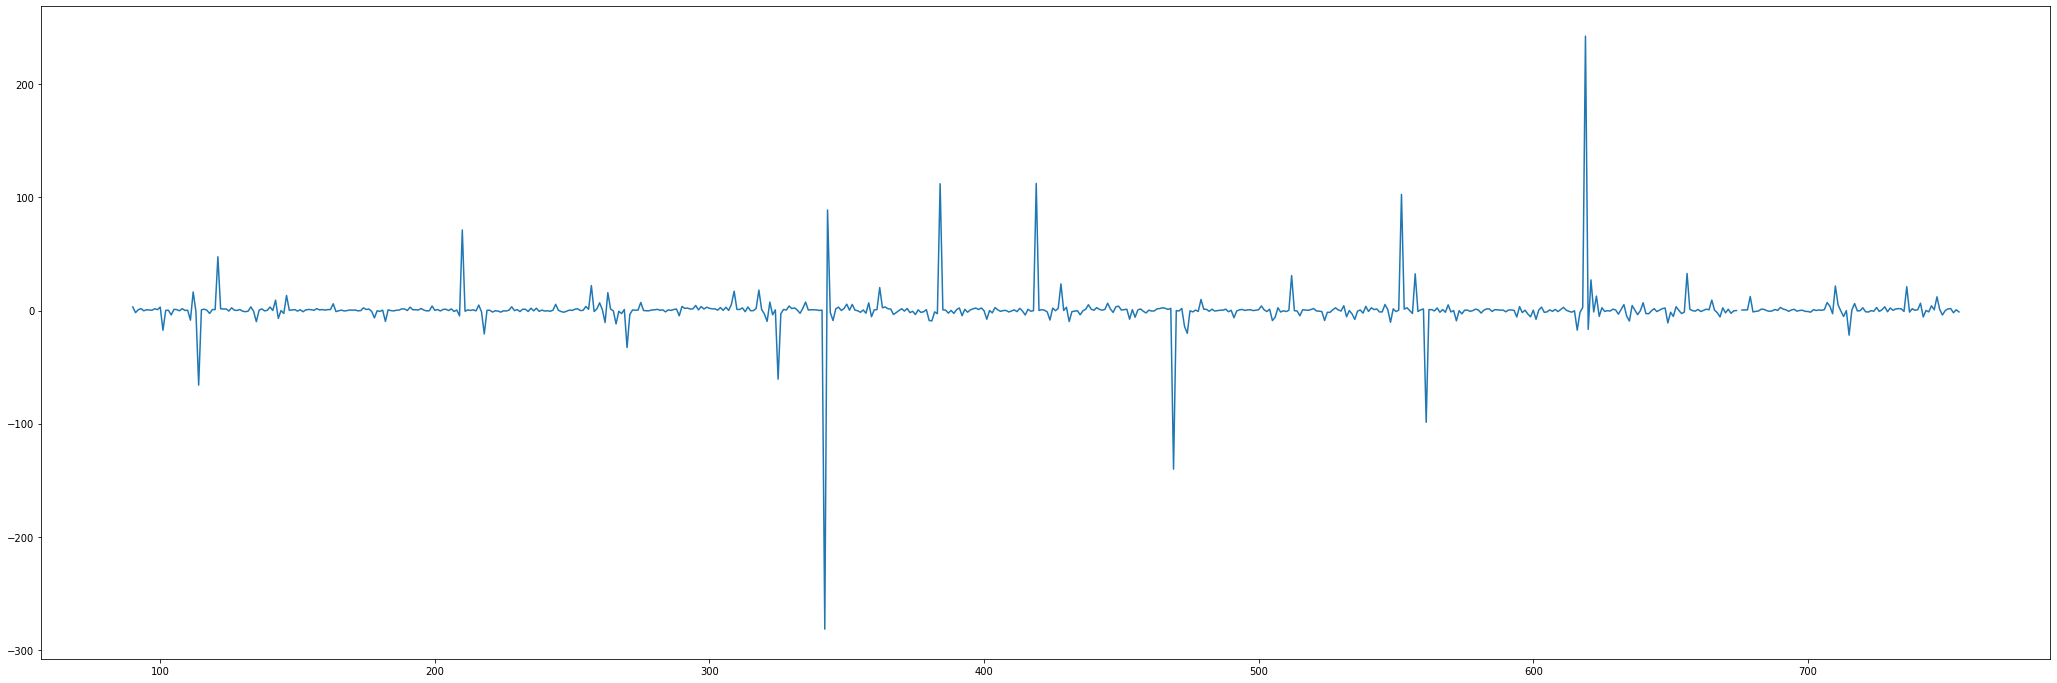

In [18]:
plt.figure(figsize=(36, 12))


df['log_ratio'][90:].plot()

# df['ratio'][60:].plot()
# df['30_mean'][60:].plot()
# df['log_up_2'][90:].plot()
# df['log_down_2'][90:].plot()


### Ratio Chart

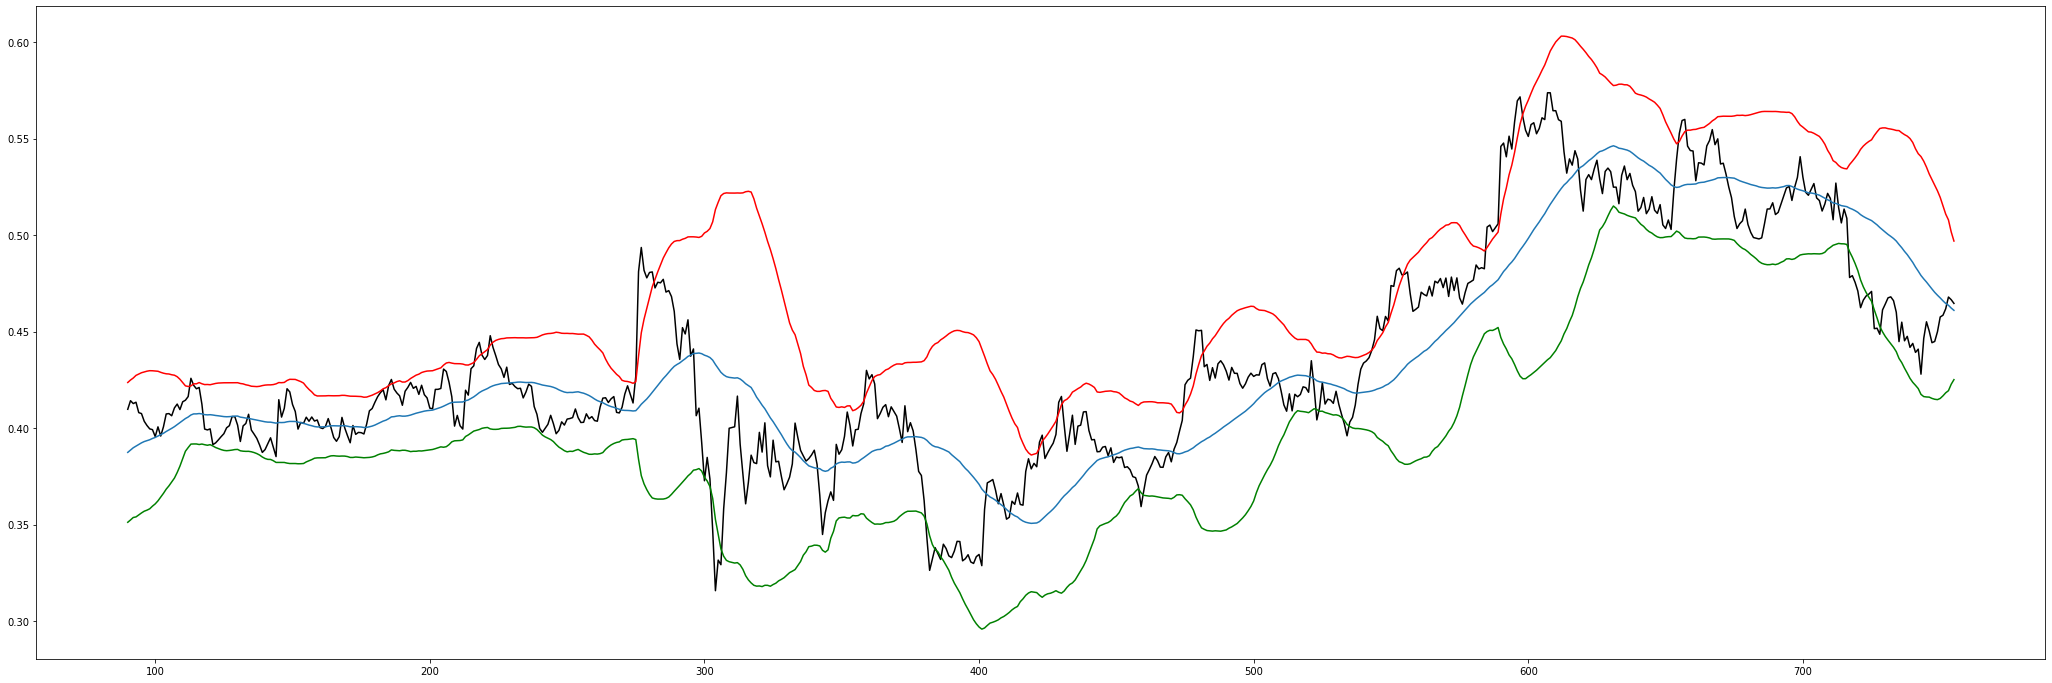

In [19]:
plt.figure(figsize=(36, 12))


df['ratio'][90:].plot(color='k')


df['30_mean'][90:].plot()
df['up_2'][90:].plot(color='r')
df['down_2'][90:].plot(color='g')


# df['up_1'][60:].plot()
# df['down_1'][60:].plot()

# Pairs Search

## Pairs Download

In [46]:
start = '2019-01-02'
end = '2022-01-21'

# end = today

In [47]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df_table = first_table
symbols = df_table['Symbol'].values.tolist()



In [48]:

symbols = symbols[:100]  #reduce number for testing

stock_list = []

stock_list = symbols


data = yf.download(stock_list, start,end)

[*********************100%***********************]  100 of 100 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [49]:
df = data['Adj Close']
df.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [50]:
tickers = df.columns.to_list()
df.corr(method='pearson')

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMY,BR,BRK.B,BRO,BSX,BWA,BXP,CAH,CARR,CAT,CBOE,CBRE,CCL,CDAY,CDNS,CDW,CE,CERN,CHRW,CNC,CNP,COF,CPB,CTLT,CZR,GOOG,GOOGL,KMX,LNT,MMM,MO,T,TECH
A,1.000000,-0.350732,0.826832,0.937404,0.924304,0.941166,0.676993,0.936459,0.955085,0.947404,0.963600,0.939097,0.847937,0.912571,0.819315,0.289394,0.859093,0.517233,0.429488,0.893289,0.952580,0.754921,0.959686,0.963751,0.104863,0.792818,0.809580,0.957872,0.860980,0.906156,0.944895,0.573247,0.948445,0.785775,0.873870,0.791671,0.883429,0.887987,0.903038,0.915056,...,0.188819,0.961767,0.631887,0.778278,0.392564,0.982936,0.816002,0.735603,0.931514,NaN,0.907943,0.395785,0.706274,-0.048427,0.642327,0.947109,0.904473,0.403382,0.911371,-0.508344,0.915726,0.955873,0.926465,0.882116,0.671661,0.725369,0.664177,0.108861,0.870459,0.274637,0.953008,0.894183,0.980710,0.980255,0.886343,0.784565,0.636292,0.651069,-0.321292,0.981747
AAL,-0.350732,1.000000,0.075117,-0.562140,-0.429813,-0.441286,-0.019014,-0.497691,-0.348109,-0.545269,-0.279022,-0.192902,-0.029587,-0.496480,-0.349616,0.013454,-0.111859,0.505177,0.533158,-0.222639,-0.341933,-0.719208,-0.250987,-0.248220,0.783106,-0.032727,-0.123403,-0.288353,-0.175311,-0.556252,-0.282509,-0.652766,-0.201279,-0.586469,-0.638952,-0.045886,-0.617871,-0.121409,-0.247488,-0.163984,...,-0.093038,-0.557166,0.380858,0.124992,0.612942,-0.368924,-0.522708,-0.578394,-0.334456,NaN,-0.465872,0.348569,0.169458,0.814561,-0.314119,-0.570997,-0.188406,0.303716,-0.059880,0.959528,-0.520583,-0.475370,-0.213910,-0.047378,-0.383910,-0.243458,-0.404050,0.781082,0.065301,-0.707104,-0.526408,-0.014482,-0.316804,-0.317783,-0.261024,-0.330620,0.292887,0.321155,0.307910,-0.336454
AAP,0.826832,0.075117,1.000000,0.709200,0.771411,0.770159,0.697487,0.731329,0.857601,0.704064,0.841059,0.881129,0.885483,0.647804,0.697509,0.276948,0.743670,0.770473,0.707219,0.767100,0.842714,0.437934,0.868255,0.815864,0.396136,0.711336,0.693001,0.834383,0.803573,0.712029,0.827575,0.250242,0.896330,0.542120,0.599030,0.888314,0.593124,0.905062,0.823327,0.920464,...,-0.000832,0.710294,0.877874,0.830083,0.682609,0.818954,0.560820,0.405503,0.820276,NaN,0.758199,0.571988,0.832090,0.317888,0.419945,0.701592,0.796371,0.584476,0.900729,-0.097951,0.655303,0.773648,0.837715,0.888634,0.523468,0.736855,0.553778,0.535847,0.886449,-0.076882,0.702047,0.847428,0.856972,0.858139,0.791620,0.647812,0.752949,0.803837,-0.266642,0.829997
AAPL,0.937404,-0.562140,0.709200,1.000000,0.942045,0.944200,0.578411,0.972927,0.940758,0.958726,0.917692,0.886202,0.763005,0.932744,0.825947,0.297314,0.811934,0.338076,0.250298,0.845652,0.937075,0.873019,0.888230,0.890624,-0.078626,0.678654,0.744786,0.914347,0.823539,0.967435,0.927550,0.716342,0.895806,0.815014,0.947190,0.712067,0.969498,0.813662,0.849921,0.855089,...,0.097476,0.966628,0.443734,0.678160,0.188869,0.948967,0.884330,0.811312,0.918289,NaN,0.942081,0.260284,0.618934,-0.247701,0.664198,0.962723,0.856071,0.257360,0.808217,-0.691271,0.935018,0.971421,0.870734,0.803650,0.768943,0.762643,0.701448,-0.099171,0.722021,0.489008,0.966182,0.783356,0.922845,0.923452,0.871583,0.794817,0.455758,0.483622,-0.308076,0.913234
ABBV,0.924304,-0.429813,0.771411,0.942045,1.000000,0.937603,0.602856,0.915225,0.921632,0.888526,0.912017,0.913284,0.808188,0.895617,0.774247,0.262426,0.815386,0.442945,0.327467,0.822251,0.929588,0.779085,0.895766,0.893229,0.036476,0.729427,0.774320,0.935941,0.809613,0.905021,0.921168,0.683939,0.918928,0.752503,0.865417,0.767480,0.890167,0.873746,0.838810,0.890539,...,0.191404,0.904999,0.578206,0.705938,0.320090,0.946647,0.755805,0.811476,0.869553,NaN,0.906779,0.278446,0.679710,-0.100098,0.735270,0.917209,0.883333,0.329526,0.851017,-0.569090,0.867359,0.920353,0.875008,0.821471,0.737886,0.708273,0.795381,-0.004680,0.783737,0.397617,0.898808,0.814956,0.929403,0.928904,0.838075,0.74

### Build Cointegration Dataframe

In [51]:
from sys import version
n =  (len(df.columns) - 1)

results_list = []


#   #FOR LOOP TO RUN COINTEGRATION ACROSS ALL TICKERS, TAKES A WHILE (>20min)

# for i in range(0, n):
#   # print(df[tickers[i]].head())
#   S1 = df[tickers[i]]
#   for j in range(0,n):
#     S2 = df[tickers[j]]
#     coint_p = ts.coint(S1,S2)[1]
#     result = (tickers[i], tickers[j], coint_p)
#     results_list.append(result)






In [52]:
# results_list

In [53]:
df_coint = pd.DataFrame(results_list, columns =['S1', 'S2', 'p_value'])

In [54]:
df_coint

,S1,S2,p_value


In [55]:
df_preselects = df_coint[(df_coint['p_value'] <= .05) & (df_coint['p_value'] != 0.0)]  #remove self matches and institute cutoff
print(len(df_preselects) / 2)
df_preselects.sort_values('p_value', ascending=True, inplace=True)
df_preselects.reset_index(drop=True, inplace=True)
df_preselects.head()

0.0


,S1,S2,p_value


### Read in from file or save to file if wanted...

In [56]:
# df_preselects.to_csv('/content/drive/MyDrive/df_preselects.csv')

df_preselects = pd.read_csv('/content/drive/MyDrive/df_preselects.csv')


df_preselects.tail(3)

,Unnamed: 0,S1,S2,p_value
1851,3447,AMZN,CDNS,0.049657
1852,1975,AIZ,KMX,0.049696
1853,5348,BAC,AAP,0.049794


### Select tickers for inspection

In [57]:
ticker1 = df_preselects['S1'][2]
ticker2 = df_preselects['S2'][2]

print('tickers:', ticker1,'|', ticker2)

tickers: BDX | CAH


In [58]:
df_prices = pd.DataFrame()

df_originals = df.copy().reset_index(drop=False)

# df_originals = df_originals[df_originals['Date'] >= start]

P1 = df[ticker1]
P2 = df[ticker2]

df_prices['P1'] = P1
df_prices['P2'] = P2

In [59]:
df_originals.head()
df

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMY,BR,BRK.B,BRO,BSX,BWA,BXP,CAH,CARR,CAT,CBOE,CBRE,CCL,CDAY,CDNS,CDW,CE,CERN,CHRW,CNC,CNP,COF,CPB,CTLT,CZR,GOOG,GOOGL,KMX,LNT,MMM,MO,T,TECH
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,64.262291,31.963156,154.064529,38.326294,75.579880,70.680328,309.959991,66.047531,134.627563,224.570007,81.133881,37.361855,122.168976,128.960007,58.777756,66.056366,12.953048,42.330990,36.145542,84.842545,68.374001,59.009998,74.658318,202.119995,59.860050,76.304611,78.369987,32.210911,8.102764,18.830000,66.145241,175.788925,100.580917,148.210098,1539.130005,52.637501,143.009995,245.762375,140.249542,41.103977,...,304.690002,228.080002,43.703487,1721.699951,18.960562,361.369812,43.619846,47.246048,90.414818,0.0,26.395950,34.459999,33.345795,97.932098,40.197849,0.000000,116.861320,95.889999,39.930000,47.317490,33.759998,43.230000,76.560547,85.419601,50.322254,76.931747,56.500000,25.333364,73.602333,29.048521,30.910000,37.950001,1045.849976,1054.680054,62.970001,37.714924,172.615356,39.336227,23.726349,139.863724
2019-01-03,61.894878,29.581665,158.874222,34.508717,73.089615,69.655014,302.290009,62.930485,130.031128,215.699997,76.232994,37.197620,118.479668,121.849998,58.925789,65.902405,12.943912,41.261547,35.351837,83.486580,67.090027,57.700001,69.477852,184.779999,56.551788,75.052193,77.045311,30.344444,8.102764,17.049999,64.263496,173.114090,97.916397,149.098923,1500.280029,49.900002,137.639999,239.401917,138.146393,40.111118,...,307.000000,224.300003,42.838623,1663.119995,18.834454,350.753845,43.219475,40.979263,89.054970,0.0,26.064415,32.910000,32.339619,98.344826,39.386227,0.000000,112.358124,95.589996,37.889999,44.963482,33.230000,41.529999,74.587784,82.301010,49.187168,74.094780,54.959999,25.478125,72.554428,29.408701,29.840000,37.380001,1016.059998,1025.469971,61.889999,37.779072,166.115723,39.120846,23.758474,134.127670
2019-01-04,64.037270,31.530159,154.932816,35.981869,75.444344,70.461975,313.440002,64.726593,135.087204,226.190002,78.083809,38.055256,123.201599,128.279999,59.758465,66.509186,13.373244,41.773018,36.656441,85.172119,68.782982,59.380001,72.870964,186.710007,58.381062,77.267319,76.871254,32.422573,8.102764,19.000000,66.694084,179.031738,103.161575,149.694641,1575.390015,50.617500,143.660004,240.837845,140.746140,41.718594,...,318.329987,226.279999,44.080719,1717.550049,19.780233,363.596893,44.518215,42.586838,92.126495,0.0,26.707981,34.209999,33.554619,100.049553,40.064068,0.000000,118.497993,98.360001,39.450001,47.507332,34.389999,43.259998,75.313049,85.653725,50.671513,76.662880,56.764999,25.948603,75.774399,29.570787,31.080000,39.450001,1070.709961,1078.069946,63.610001,38.237339,172.949829,40.125980,24.368902,142.406525
2019-01-07,65.397072,32.425674,157.205948,35.901775,76.545471,70.965134,314.799988,65.695923,135.556427,229.259995,78.574829,38.246849,122.535072,132.720001,59.073822,66.137863,13.437186,41.996204,36.866268,85.511108,68.583244,61.240002,73.195946,189.919998,58.497829,77.145798,77.673805,32.999825,8.277020,20.570000,66.586266,181.440933,103.636719,150.621292,1629.510010,52.480000,147.320007,241.261902,140.434555,42.465603,...,322.399994,233.669998,43.979507,1711.819946,20.311668,364.608398,45.348244,43.967342,92.383232,0.0,26.688478,34.419998,34.427891,100.677605,40.848938,0.000000,118.571983,96.550003,40.009998,48.067356,35.910000,43.419998,75.013275,86.459137,50.380466,77.033745,57.250000,26.048128,76.193573,30.336164,32.000000,40.799999,1068.390015,1075.920044,66.430000,37.971546,172.552063,38.913425,24.810659,143.776474
2019-01-08,66.355774,31.904114,156.113281,36.586174,76.901230,71.724632,318.420013,64.907143,138.984634,232.679993,80.491760,38.958508,123.257927,133.869995,60.008274,66.952934,13.747768,42.126408,37.012230,85.614700,68.887589,62

In [60]:
df['ALL'].head()

Date
2019-01-02    76.304611
2019-01-03    75.052193
2019-01-04    77.267319
2019-01-07    77.145798
2019-01-08    77.136467
Name: ALL, dtype: float64

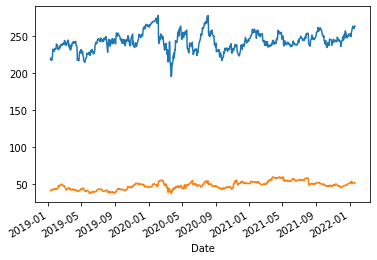

In [61]:
P1[5:].plot()
P2[5:].plot()

In [62]:
# Residuals


# S1 = sm.add_constant(S1)
# results = sm.OLS(S2, S1).fit()
# S1 = S1['ABGB']
# b = results.params['ABGB']

# spread = S2 - b * S1
# spread.plot()
# plt.axhline(spread.mean(), color='black')
# plt.legend(['Spread']);

In [63]:
# # Coefficient plotting


# R1 = df_prices['P1'][1:]
# R2 = df_prices['P2'][1:]


# R1 = sm.add_constant(R1)
# # print(R1)
# results = sm.OLS(R2, R1).fit()

# # drop constants columns
# R1 = df_prices['P1'][1:]
# b = results.params['P1']

# print("b-TERM:", b, '\n')

# spread = R2 - (b * R1)

# df_prices['spread'] = df_prices['P2'] - (b * df_prices['P1'])

# spread.plot()
# plt.axhline(spread.mean(), color='black')
# plt.legend(['Spread']);

In [64]:
# stationarity(spread)

In [65]:
window = 30    #SELECT NUMBER OF DAYS FOR LOOKBACK
zs = 2.0


df_prices['ratio'] = df_prices['P1'] / df_prices['P2']
df_prices['mean'] = df_prices['ratio'].rolling(window=window).mean()
df_prices['stdev'] = df_prices['ratio'].rolling(window=window).std()


df_prices['z_score'] = (df_prices['ratio'] - df_prices['mean'].shift(0)) / df_prices['stdev'].shift(0)
df_prices['z_up'] = df_prices['mean'] + (df_prices['stdev'] * zs)
df_prices['z_dwn'] = df_prices['mean'] - (df_prices['stdev'] * zs)


# s_mean = df_prices['spread'].mean()
# stdev = df_prices['spread'].std()
# df_prices['spread_Z'] = (df_prices['spread'] - s_mean) / stdev




df_prices.fillna(0, inplace=True)



df_prices.head(3)

,P1,P2,ratio,mean,stdev,z_score,z_up,z_dwn
Date,,,,,,,,
2019-01-02,211.583160,40.197849,5.263544,0.0,0.0,0.0,0.0,0.0
2019-01-03,203.045975,39.386227,5.155253,0.0,0.0,0.0,0.0,0.0
2019-01-04,208.612427,40.064068,5.206971,0.0,0.0,0.0,0.0,0.0


In [66]:
# df_prices['spread_Z'][window:].plot()
# plt.axhline(0.0, color='k', linestyle='-')

In [67]:
stationarity(df_prices['ratio'])

The series is stationary
p-value =  0.028516889266034375


In [68]:
co_check = ts.coint(df_prices['P1'][1:], df_prices['P2'][1:])
print(co_check[1])

0.002256566350938819


###Charts

''

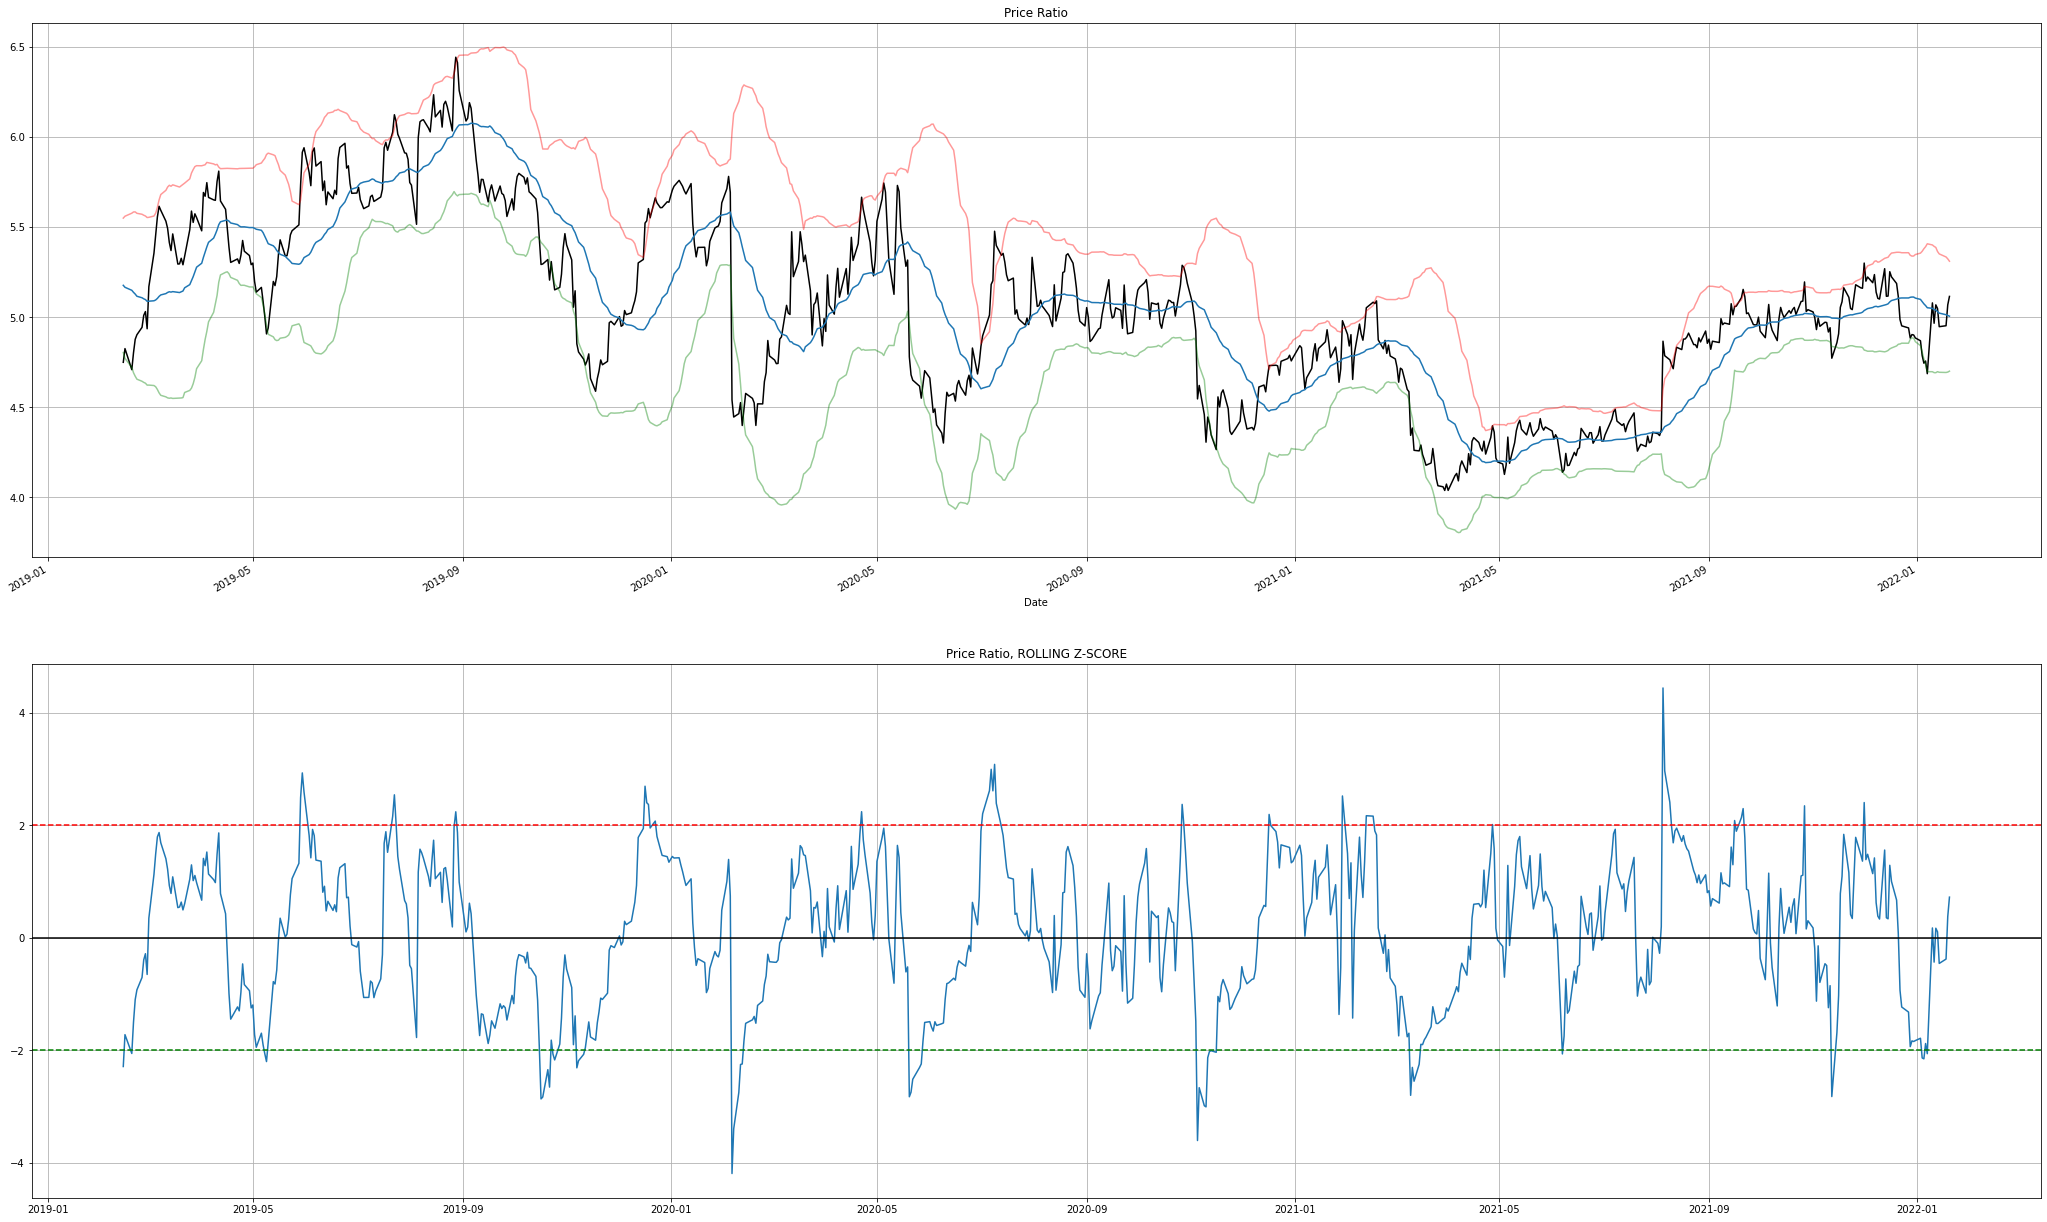

In [69]:
plt.figure(figsize=(36, 12 * 2))

# plt.subplot(3,1,1)
# plt.title('Coefficient Plot')
# plt.grid()
# df_prices['spread_Z'][window:].plot()
# plt.axhline(0.0, color='k', linestyle='-')
# plt.axhline(zs, color='r', linestyle='--')
# plt.axhline(-zs, color='g', linestyle='--')
# plt.legend(['Spread'])
# plt.grid();


plt.subplot(2,1,1)
df_prices['ratio'][window:].plot(color='k')
df_prices['mean'][window:].plot()
df_prices['z_up'][window:].plot(color='r', alpha=.4)
df_prices['z_dwn'][window:].plot(color='g', alpha=.4)
plt.title('Price Ratio')
plt.grid()


plt.subplot(2,1,2)
plt.title('Price Ratio, ROLLING Z-SCORE')
plt.plot(df_prices['z_score'][window:])
plt.axhline(0.0, color='k', linestyle='-')
plt.axhline(zs, color='r', linestyle='--')
plt.axhline(-zs, color='g', linestyle='--')
# plt.title('Price Ratio, ROLLING Z-SCORE')
plt.grid()


;

#Build BackTest

In [144]:
df_bt = df_prices.copy()




In [152]:
def trade_position(high, low, close):
  
  # if either oof is a number display that number, if close is 1.0 then zero, if not np.nan
  
  
  if high == -1:
    pos = -1
  elif low == 1:
    pos = 1
  elif close == 1:
    pos = 0
  else:
    pos = np.nan
  return pos

  

In [156]:
df_bt['oor_high'] = (df_bt['ratio'] > df_bt['z_up']).astype(int) * -1
df_bt['oor_low'] = (df_bt['ratio'] < df_bt['z_dwn']).astype(int)

df_bt['close_trade'] = df_bt['z_score'].apply(lambda x:  1 if abs(x) <= .35 else np.nan)

df_bt['close_trade'].fillna(0, inplace=True)

df_bt['volume_round'] = round(df_bt['mean'], 0)

# df_bt['pre_direction'] =  (df_bt['oor_high'] + df_bt['oor_low']) * df_bt['close_trade']
df_bt['pre_direction'] =  (df_bt['oor_high'] + df_bt['oor_low'])




# df_bt['P1_direction'] = df_bt['pre_direction'].apply(lambda x:  x * 1 if x != 0 else np.nan)
# # # df_bt['P1_direction'].ffill(inplace=True)

# df_bt['position_1'] = df_bt['P1_direction'] * df_bt['close_trade']

df_bt['trade_position'] = df_bt.apply(lambda x: trade_position(x['oor_high'], x['oor_low'] ,x['close_trade']), axis=1)
df_bt['trade_position'].ffill(inplace=True)

In [158]:
df_bt[85:125]

,P1,P2,ratio,mean,stdev,z_score,z_up,z_dwn,oor_high,oor_low,close_trade,volume_round,pre_direction,trade_position
Date,,,,,,,,,,,,,,
2019-05-06,230.023743,44.537849,5.164680,5.481894,0.186723,-1.698850,5.855341,5.108448,0,0,0.0,5.0,0,0.0
2019-05-07,224.266373,44.087429,5.086855,5.468631,0.200161,-1.907341,5.868953,5.068309,0,0,0.0,5.0,0,0.0
2019-05-08,224.054230,44.781075,5.003324,5.449126,0.215967,-2.064217,5.881060,5.017193,0,1,0.0,5.0,1,1.0
2019-05-09,221.614334,45.168442,4.906398,5.428487,0.236974,-2.203155,5.902434,4.954540,0,1,0.0,5.0,1,1.0
2019-05-10,217.371078,44.006344,4.939540,5.407362,0.251427,-1.860669,5.910215,4.904508,0,0,0.0,5.0,0,1.0
2019-05-13,215.722000,41.501999,5.197870,5.395548,0.252706,-0.782245,5.900959,4.890136,0,0,0.0,5.0,0,1.0
2019-05-14,214.902267,41.529018,5.174750,5.385412,0.255335,-0.825045,5.896082,4.874742,0,0,0.0,5.0,0,1.0
2019-05-15,217.380722,41.601089,5.225361,5.369866,0.250186,-0.577588,5.870237,4.869494,0,0,0.0,5.0,0,1.0
2019-05-16,217.882187,40.745281,5.347421,5.359088,0.243657,-0.047883,5.846402,4.871775,0,0,1.0,5.0,0,0.0


In [148]:
# TODO

'''

Need to cut out the window period for PnL testing!!!

Define closing trade out around the 'close_open',

ffill oor's ?

use oor's and close_open to create a position column

calc log returns of both P1 and P2(?)...this remove the need for weighting need to think about it, tired now.

create a $-ratio columns for putting the trade on and ffill to close out the same size?

use oor's and close_open and $-ratio to create a position column for both P1 and P2

shift evrything forward by at least (1), test diff lags?

OOS testing? after confirmation its working correctly...

calc returns for both... sum at the end... T1

put the T1 back in the matrix along with the dates?

calc buy and hold for both...

calc sharpe ratios and risk metrics:  is risk lower than just buy and hold?

max up, max down, VaR, Sharpe, etc...

How do we push .csv to GitHub?

VERY TIRED...















'''

"\n\nNeed to cut out the window period for PnL testing!!!\n\nDefine closing trade out around the 'close_open',\n\nffill oor's ?\n\nuse oor's and close_open to create a position column\n\ncalc log returns of both P1 and P2(?)...this remove the need for weighting need to think about it, tired now.\n\ncreate a $-ratio columns for putting the trade on and ffill to close out the same size?\n\nuse oor's and close_open and $-ratio to create a position column for both P1 and P2\n\nshift evrything forward by at least (1), test diff lags?\n\nOOS testing? after confirmation its working correctly...\n\ncalc returns for both... sum at the end... T1\n\nput the T1 back in the matrix along with the dates?\n\ncalc buy and hold for both...\n\ncalc sharpe ratios and risk metrics:  is risk lower than just buy and hold?\n\nmax up, max down, VaR, Sharpe, etc...\n\nHow do we push .csv to GitHub?\n\nVERY TIRED...\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n"